### Automated Feature Engineering Basic

### Automated Feature Engineering by Deep Feature Synthesis using Feature Tools Library

### The work done in this notebook is done on subset of the data based on the methods applied on the entire dataset with the results [available here](https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools)

In [1]:
#!pip install featuretools

In [2]:
PATH = 'D:\IPYNB\Ipynb project\project'

In [3]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

### Subsetting the data

In [4]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allowed us to  see the results in a reasonable amount of time
app_train = pd.read_csv(f'{PATH}/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
app_test = pd.read_csv(f'{PATH}/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
bureau = pd.read_csv(f'{PATH}/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:1000, :]
bureau_balance = pd.read_csv(f'{PATH}/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:1000, :]
cash = pd.read_csv(f'{PATH}/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
credit = pd.read_csv(f'{PATH}/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
previous = pd.read_csv(f'{PATH}/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
installments = pd.read_csv(f'{PATH}/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]

### We joined the train and test set together but add a separate column identifying the set. This is important because we want to apply the same exact procedures to each dataset.

### We are not sure if this is allowing data leakage into the train set and if these feature creation operations should be applied separately.

In [5]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

### An entity is simply a table or a dataframe of pandas

### An entity in featuretools must have a unique index where none of the elements are duplicate
### app, bureau, and previous have unique indices (SK_ID_CURR, SK_ID_BUREAU, and SK_ID_PREV respectively).
### For the other dataframes, we must pass in make_index = True and then specify the name of the index.
### Entities can also have time indices where each entry is identified by a unique time but here we didn't have any time indices

### An EntitySet is a collection of tables and the relationships between them.

### First we'll make an empty entityset named clients to keep track of all the data.

In [6]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

### Now we define our entities

In [7]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

### Relationships are a the same concept in featuretools as in any relational database.

### In a parent table, each individual has a single row. Each individual in the parent table can have multiple rows in the child table.

### The app dataframe has one row for each client (SK_ID_CURR) while the bureau dataframe has multiple previous loans (SK_ID_PREV) for each parent (SK_ID_CURR). Therefore, the bureau dataframe is the child of the app dataframe. The bureau dataframe in turn is the parent of bureau_balance because each loan has one row in bureau but multiple monthly records in bureau_balance.

### The app and bureau dataframe are linked by the SK_ID_CURR variable while the bureau and bureau_balance dataframes are linked with the SK_ID_BUREAU

### For each relationship, we need to specify the parent variable and the child variable. Altogether, there are a total of 6 relationships between the tables. Below we specify all six relationships and then add them to the EntitySet.

In [8]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n', app.iloc[:, 111:115].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

    SK_ID_CURR  TARGET  TOTALAREA_MODE WALLSMATERIAL_MODE
0      100002     1.0          0.0149       Stone, brick
1      100003     0.0          0.0714              Block
2      100004     0.0             NaN                NaN
3      100006     0.0             NaN                NaN
4      100007     0.0             NaN                NaN

Child: bureau, Child Variable: SK_ID_CURR

     SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
10      100002       6158905        Closed      currency 1
11      100002       6158906        Closed      currency 1
12      100002       6158907        Closed      currency 1
13      100002       6158908        Closed      currency 1
14      100002       6158909        Active      currency 1


### Below we specify all six relationships and then add them to the EntitySet.

In [9]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [10]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 2002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

### A [feature primitive](https://docs.featuretools.com/automated_feature_engineering/primitives.html) is an operation applied to a table or a set of tables to create a feature.

### Feature primitives fall into two categories:

* __Aggregation__: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum previous loan amount for each client. An aggregation works across multiple tables using relationships between tables.
* __Transformation__: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.

### Below we explore some aggregation and transformation primitives that are available in feature tools

In [11]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

name         type  \
0  time_since_first  aggregation   
1               std  aggregation   
2        num_unique  aggregation   
3   time_since_last  aggregation   
4              mode  aggregation   
5     n_most_common  aggregation   
6               sum  aggregation   
7               all  aggregation   
8               max  aggregation   
9              last  aggregation   

                                                               description  
0                                       Time since first related instance.  
1  Finds the standard deviation of a numeric feature ignoring null values.  
2                      Returns the number of unique categorical variables.  
3                                        Time since last related instance.  
4                  Finds the most common element in a categorical feature.  
5               Finds the N most common elements in a categorical feature.  
6                           Sums elements of a numeric or boolean feature.  
7                                           Test if all values are 'True'.  
8                   Finds the maximum non-null value of a numeric feature.  
9                                                  Returns the last value.

In [12]:
primitives[primitives['type'] == 'transform'].head(10)

name       type  \
20                   second  transform   
21       add_numeric_scalar  transform   
22           modulo_numeric  transform   
23       less_than_equal_to  transform   
24                cum_count  transform   
25  multiply_numeric_scalar  transform   
26    greater_than_equal_to  transform   
27                     isin  transform   
28         multiply_numeric  transform   
29        modulo_by_feature  transform   

                                                                     description  
20                                 Transform a Datetime feature into the second.  
21                                                                                
22                                                                                
23                                                                                
24                                   Returns the cumulative count after grouping  
25                                                                                
26                                                                                
27  For each value of the base feature, checks whether it is in a provided list.  
28                                                                                
29

### Deep Feature Synthesis (DFS) is a process of featuretools which creates new features

### DFS stacks feature primitives to form features with a "depth" equal to the number of primitives.

### If we take the maximum value of a client's previous loans MAX(previous.loan_amount), that is a "deep feature" with a depth of 1. To create a feature with a depth of two, we could stack primitives by taking the maximum value of a client's average montly payments per previous loan MAX(previous(MEAN(installments.payment))).

### we use the dfs function, pass it an entityset, the target_entity (where we want to make the features), the agg_primitives to use, the trans_primitives to use and the max_depth of the features.

### we can run the function using features_only = True to return only a list of the features and not calculate the features themselves to look at the resulting features before starting an extended computation.

### Using a computer with 64GB of ram, this function call took around 24 hours

### The script to run this call is available [here](https://www.kaggle.com/willkoehrsen/feature-engineering-using-feature-tools)

### The entire dataset available [here](https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools/data) in the file called feature_matrix.csv.

In [13]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))

1697 Total Features


### We generate a subset of the features

In [14]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 1697 features
Elapsed: 00:18 | Remaining: 00:00 | Progress: 100%|█████████████████████████████████████████████| Calculated: 11/11 chunks


AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
SK_ID_CURR                                                               
100001          20560.5    568800.0         450000.0          135000.0   
100002          24700.5    406597.5         351000.0          202500.0   
100003          35698.5   1293502.5        1129500.0          270000.0   
100004           6750.0    135000.0         135000.0           67500.0   
100005          17370.0    222768.0         180000.0           99000.0   
100006          29686.5    312682.5         297000.0          135000.0   
100007          21865.5    513000.0         513000.0          121500.0   
100008          27517.5    490495.5         454500.0           99000.0   
100009          41301.0   1560726.0        1395000.0          171000.0   
100010          42075.0   1530000.0        1530000.0          360000.0   

            AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
SK_ID_CURR                                                          
100001                            0.0                         0.0   
100002                            0.0                         0.0   
100003                            0.0                         0.0   
100004                            0.0                         0.0   
100005                            0.0                         0.0   
100006                            NaN                         NaN   
100007                            0.0                         0.0   
100008                            0.0                         0.0   
100009                            0.0                         0.0   
100010                            0.0                         0.0   

            AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                         
100001                            0.0                        0.0   
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100005                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   
100008                            0.0                        1.0   
100009                            1.0                        1.0   
100010                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  \
SK_ID_CURR                                                           
100001                             0.0                         0.0   
100002                             0.0                         1.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100005                             0.0                         3.0   
100006                             NaN                         NaN   
100007                             0.0                         0.0   
100008                             0.0                         1.0   
100009                             0.0                         2.0   
100010                             0.0                         0.0   

            APARTMENTS_AVG  APARTMENTS_MEDI  APARTMENTS_MODE  \
SK_ID_CURR                                                     
100001              0.0660           0.0666           0.0672   
100002              0.0247           0.0250           0.0252   
100003              0.0959           0.0968           0.0924   
100004                 NaN              NaN              NaN   
100005                 NaN              NaN              NaN   
100006                 NaN              NaN              NaN   
100007                 NaN              NaN              NaN   
100008                 NaN              NaN              NaN

In [15]:
feature_names[-20:]

[<Feature: MEAN(previous.SKEW(cash.SK_DPD))>,
 <Feature: MEAN(previous.SKEW(cash.SK_DPD_DEF))>,
 <Feature: MEAN(previous.MIN(cash.SK_ID_CURR))>,
 <Feature: MEAN(previous.MIN(cash.MONTHS_BALANCE))>,
 <Feature: MEAN(previous.MIN(cash.CNT_INSTALMENT))>,
 <Feature: MEAN(previous.MIN(cash.CNT_INSTALMENT_FUTURE))>,
 <Feature: MEAN(previous.MIN(cash.SK_DPD))>,
 <Feature: MEAN(previous.MIN(cash.SK_DPD_DEF))>,
 <Feature: MEAN(previous.MEAN(cash.SK_ID_CURR))>,
 <Feature: MEAN(previous.MEAN(cash.MONTHS_BALANCE))>,
 <Feature: MEAN(previous.MEAN(cash.CNT_INSTALMENT))>,
 <Feature: MEAN(previous.MEAN(cash.CNT_INSTALMENT_FUTURE))>,
 <Feature: MEAN(previous.MEAN(cash.SK_DPD))>,
 <Feature: MEAN(previous.MEAN(cash.SK_DPD_DEF))>,
 <Feature: MEAN(previous.COUNT(cash))>,
 <Feature: MEAN(previous.NUM_UNIQUE(cash.NAME_CONTRACT_STATUS))>,
 <Feature: NUM_UNIQUE(previous.MODE(credit.NAME_CONTRACT_STATUS))>,
 <Feature: NUM_UNIQUE(previous.MODE(cash.NAME_CONTRACT_STATUS))>,
 <Feature: MODE(previous.MODE(credit.NAM

### We run on the selected aggregation primitives which generates 884 features on the entire dataset, before we reached to 1697 Total Features all of which might not be relevant to the problem. This could have led to decrease in the performance by drowning out the important features (related to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality))

### This call takes about 12 hours to run on the complete dataset on a pc with 16gb ram

In [16]:
# Specify the aggregation primitives
feature_matrix_spec, feature_names_spec = ft.dfs(entityset = es, target_entity = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 884 features
Elapsed: 00:07 | Remaining: 00:00 | Progress: 100%|█████████████████████████████████████████████| Calculated: 11/11 chunks


In [17]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
SK_ID_CURR                                                               
100001          20560.5    568800.0         450000.0          135000.0   
100002          24700.5    406597.5         351000.0          202500.0   
100003          35698.5   1293502.5        1129500.0          270000.0   
100004           6750.0    135000.0         135000.0           67500.0   
100005          17370.0    222768.0         180000.0           99000.0   
100006          29686.5    312682.5         297000.0          135000.0   
100007          21865.5    513000.0         513000.0          121500.0   
100008          27517.5    490495.5         454500.0           99000.0   
100009          41301.0   1560726.0        1395000.0          171000.0   
100010          42075.0   1530000.0        1530000.0          360000.0   

            AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
SK_ID_CURR                                                          
100001                            0.0                         0.0   
100002                            0.0                         0.0   
100003                            0.0                         0.0   
100004                            0.0                         0.0   
100005                            0.0                         0.0   
100006                            NaN                         NaN   
100007                            0.0                         0.0   
100008                            0.0                         0.0   
100009                            0.0                         0.0   
100010                            0.0                         0.0   

            AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                         
100001                            0.0                        0.0   
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100005                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   
100008                            0.0                        1.0   
100009                            1.0                        1.0   
100010                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  \
SK_ID_CURR                                                           
100001                             0.0                         0.0   
100002                             0.0                         1.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100005                             0.0                         3.0   
100006                             NaN                         NaN   
100007                             0.0                         0.0   
100008                             0.0                         1.0   
100009                             0.0                         2.0   
100010                             0.0                         0.0   

            APARTMENTS_AVG  APARTMENTS_MEDI  APARTMENTS_MODE  \
SK_ID_CURR                                                     
100001              0.0660           0.0666           0.0672   
100002              0.0247           0.0250           0.0252   
100003              0.0959           0.0968           0.0924   
100004                 NaN              NaN              NaN   
100005                 NaN              NaN              NaN   
100006                 NaN              NaN              NaN   
100007                 NaN              NaN              NaN   
100008                 NaN              NaN              NaN

### we made a ton of features, some are likely to be correlated with the target simply because of random noise. Using correlations is fine as a first approximation for identifying "good features", but it is not a rigorous feature selection method.

### Features that are highly correlated with one another can diminish interpretability and generalization performance on the test set.

### The following correlations were calculated using the entire training section of the feature_matrix_spec.

In [18]:
correlations = pd.read_csv(f'{PATH}/home-credit-default-risk-feature-tools/correlations_spec.csv', index_col = 0)
correlations.index.name = 'Variable'
correlations.head()

SK_ID_CURR  FLAG_EMP_PHONE  \
Variable                                                  
SK_ID_CURR                     1.000000       -0.001337   
FLAG_EMP_PHONE                -0.001337        1.000000   
DEF_60_CNT_SOCIAL_CIRCLE       0.001187       -0.014034   
LIVE_REGION_NOT_WORK_REGION    0.002903        0.096447   
YEARS_BEGINEXPLUATATION_AVG    0.001551       -0.008672   

                             DEF_60_CNT_SOCIAL_CIRCLE  \
Variable                                                
SK_ID_CURR                                   0.001187   
FLAG_EMP_PHONE                              -0.014034   
DEF_60_CNT_SOCIAL_CIRCLE                     1.000000   
LIVE_REGION_NOT_WORK_REGION                 -0.016693   
YEARS_BEGINEXPLUATATION_AVG                 -0.004751   

                             LIVE_REGION_NOT_WORK_REGION  \
Variable                                                   
SK_ID_CURR                                      0.002903   
FLAG_EMP_PHONE                                  0.096447   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.016693   
LIVE_REGION_NOT_WORK_REGION                     1.000000   
YEARS_BEGINEXPLUATATION_AVG                     0.012031   

                             YEARS_BEGINEXPLUATATION_AVG  APARTMENTS_MODE  \
Variable                                                                    
SK_ID_CURR                                      0.001551         0.001961   
FLAG_EMP_PHONE                                 -0.008672         0.014720   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.004751        -0.015337   
LIVE_REGION_NOT_WORK_REGION                     0.012031         0.017831   
YEARS_BEGINEXPLUATATION_AVG                     1.000000         0.100665   

                             FLAG_MOBIL  FLOORSMIN_MEDI  BASEMENTAREA_AVG  \
Variable                                                                    
SK_ID_CURR                     0.002804        0.002837         -0.002070   
FLAG_EMP_PHONE                -0.000845        0.016486          0.001292   
DEF_60_CNT_SOCIAL_CIRCLE       0.000499       -0.020663         -0.012925   
LIVE_REGION_NOT_WORK_REGION    0.000371        0.053927          0.000965   
YEARS_BEGINEXPLUATATION_AVG   -0.000649        0.166756          0.085950   

                             LANDAREA_MODE  FLAG_DOCUMENT_21  AMT_GOODS_PRICE  \
Variable                                                                        
SK_ID_CURR                        0.001548          0.000282        -0.000232   
FLAG_EMP_PHONE                    0.008657          0.008579         0.063487   
DEF_60_CNT_SOCIAL_CIRCLE         -0.002882          0.000393        -0.024506   
LIVE_REGION_NOT_WORK_REGION      -0.006717         -0.001969         0.052864   
YEARS_BEGINEXPLUATATION_AVG       0.070008         -0.000052         0.007245   

                             COMMONAREA_MODE  APARTMENTS_MEDI  EXT_SOURCE_1  \
Variable                                                                      
SK_ID_CURR                         -0.001058         0.001988      0.000082   
FLAG_EMP_PHONE                      0.013112         0.016323     -0.294147   
DEF_60_CNT_SOCIAL_CIRCLE           -0.012114        -0.015995     -0.030508   
LIVE_REGION_NOT_WORK_REGION         0.028017         0.018141     -0.031389   
YEARS_BEGINEXPLUATATION_AVG         0.086286         0.100132      0.002120   

                             EXT_SOURCE_3  FLAG_DOCUMENT_16  \
Variable                                                      
SK_ID_CURR                       0.000222         -0.000724   
FLAG_EMP_PHONE                  -0.115293          0.043008   
DEF_60_CNT_SOCIAL_CIRCLE        -0.034096         -0.005927   
LIVE_REGION_NOT_WORK_REGION     -0.029603          0.004296   
YEARS_BEGINEXPLUATATION_AVG     -0.000406         -0.000992   

                             LIVINGAPARTMENTS_MODE  ENTRANCES_MEDI  \
Variable                                                             
SK_ID_CURR

### We explore the Correlations with the Target

In [19]:
correlations_target = correlations.sort_values('TARGET')['TARGET']
# Most negative correlations
correlations_target.head()

Variable
EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
MODE(bureau.CREDIT_ACTIVE)_Closed      -0.070201
NAME_EDUCATION_TYPE_Higher education   -0.056593
Name: TARGET, dtype: float64

In [20]:
# Most positive correlations
correlations_target.dropna().tail()

Variable
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102765
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       0.102774
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.102917
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102996
TARGET                                                      1.000000
Name: TARGET, dtype: float64

In [21]:
features_sample = pd.read_csv(f'{PATH}/home-credit-default-risk-feature-tools/feature_matrix.csv', nrows = 20000)
features_sample = features_sample[features_sample['set'] == 'train']
features_sample.head()

SK_ID_CURR NAME_TYPE_SUITE  REG_REGION_NOT_LIVE_REGION  EXT_SOURCE_2  \
1      100002   Unaccompanied                           0      0.262949   
2      100003          Family                           0      0.622246   
3      100004   Unaccompanied                           0      0.555912   
5      100006   Unaccompanied                           0      0.650442   
6      100007   Unaccompanied                           0      0.322738   

  OCCUPATION_TYPE  FLAG_PHONE  AMT_INCOME_TOTAL  AMT_CREDIT  \
1        Laborers           1          202500.0    406597.5   
2      Core staff           1          270000.0   1293502.5   
3        Laborers           1           67500.0    135000.0   
5        Laborers           0          135000.0    312682.5   
6      Core staff           0          121500.0    513000.0   

   REGION_RATING_CLIENT  REG_REGION_NOT_WORK_REGION  CNT_FAM_MEMBERS  \
1                     2                           0              1.0   
2                     1                           0              2.0   
3                     2                           0              1.0   
5                     2                           0              2.0   
6                     2                           0              1.0   

   DAYS_BIRTH  REG_CITY_NOT_LIVE_CITY  COMMONAREA_AVG  FLAG_WORK_PHONE  \
1       -9461                       0          0.0143                0   
2      -16765                       0          0.0605                0   
3      -19046                       0             NaN                1   
5      -19005                       0             NaN                0   
6      -19932                       0             NaN                0   

   HOUSETYPE_MODE  FLAG_DOCUMENT_21  ELEVATORS_AVG  LIVINGAPARTMENTS_MODE  \
1  block of flats                 0           0.00                  0.022   
2  block of flats                 0           0.08                  0.079   
3             NaN                 0            NaN                    NaN   
5             NaN                 0            NaN                    NaN   
6             NaN                 0            NaN                    NaN   

     set  FLOORSMAX_MODE  FLAG_DOCUMENT_17  AMT_REQ_CREDIT_BUREAU_QRT  \
1  train          0.0833                 0                        0.0   
2  train          0.2917                 0                        0.0   
3  train             NaN                 0                        0.0   
5  train             NaN                 0                        NaN   
6  train             NaN                 0                        0.0   

   COMMONAREA_MEDI  FLAG_EMAIL  FLAG_DOCUMENT_5       ORGANIZATION_TYPE  \
1           0.0144           0                0  Business Entity Type 3   
2           0.0608           0                0                  School   
3              NaN           0                0              Government   
5              NaN           0                0  Business Entity Type 3   
6              NaN           0                0                Religion   

  FLAG_OWN_REALTY  DAYS_REGISTRATION  DAYS_ID_PUBLISH  LANDAREA_MODE  \
1               Y            -3648.0            -2120         0.0377   
2               N            -1186.0             -291         0.0128   
3               Y            -4260.0            -2531            NaN   
5               Y            -9833.0            -2437            NaN   
6               Y            -4311.0            -3458            NaN   

   NONLIVINGAPARTMENTS_MEDI  FLAG_DOCUMENT_15  REGION_POPULATION_RELATIVE  \
1                    0.0000                 0                    0.018801   
2                    0.0039                 0                    0.003541   
3                       NaN                 0                    0.010032   
5                       NaN                 0                    0.008019   
6                       NaN                 0                    0.028663   

   LIVE_REGION_NOT_WORK_REGION  LIVINGAREA_MED

In [22]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

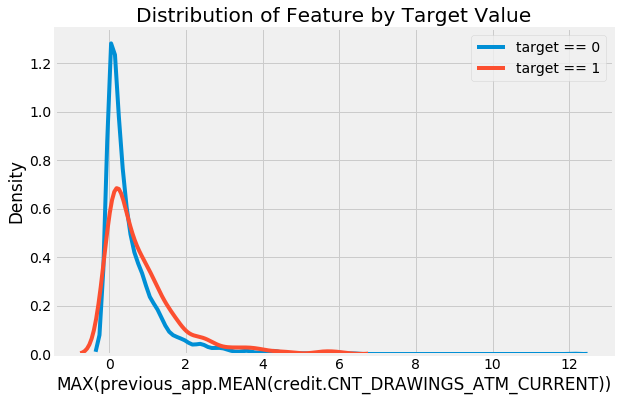

In [23]:
kde_target_plot(features_sample, feature = 'MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))')

### We look for pairs of correlated features and potentially remove any above a threshold of 90%.

In [24]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [25]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))']

In [26]:
correlations['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head()

Variable
MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)                       1.000000
MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))    0.999382
MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.999024
MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995957
SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995484
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

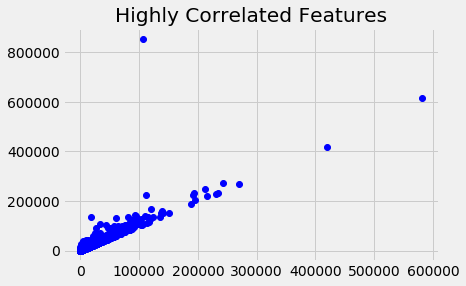

In [27]:
plt.plot(features_sample['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'], features_sample['MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))'], 'bo')
plt.title('Highly Correlated Features');

In [28]:
# Read in the feature importances and sort with the most important at the top
fi = pd.read_csv(f'{PATH}/home-credit-default-risk-feature-tools/spec_feature_importances_ohe.csv', index_col = 0)
fi = fi.sort_values('importance', ascending = False)
fi.head(15)

feature  importance
13                                       EXT_SOURCE_1       357.6
14                                       EXT_SOURCE_3       311.6
58                                       EXT_SOURCE_2       307.0
31                                         DAYS_BIRTH       228.6
55                                         AMT_CREDIT       204.4
91                                        AMT_ANNUITY       195.2
69                                      DAYS_EMPLOYED       150.2
10                                    AMT_GOODS_PRICE       144.2
186                           MAX(bureau.DAYS_CREDIT)       138.8
42                                    DAYS_ID_PUBLISH       122.8
115                   MAX(bureau.DAYS_CREDIT_ENDDATE)       121.8
62                                        OWN_CAR_AGE       104.0
518   SUM(previous_app.MIN(installments.AMT_PAYMENT))       101.8
196                     MAX(bureau.DAYS_ENDDATE_FACT)        99.6
669  MEAN(previous_app.MIN(installments.AMT_PAYMENT))        99.0

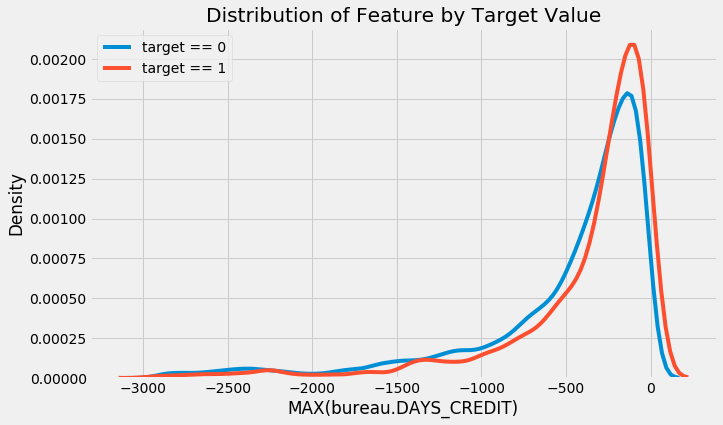

In [29]:
kde_target_plot(features_sample, feature = 'MAX(bureau.DAYS_CREDIT)')

In [30]:
# List of the original features (after one-hot)
original_features = list(pd.get_dummies(app).columns)

created_features = []

# Iterate through the top 100 features
for feature in fi['feature'][:100]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 100 features were made by featuretools' % len(created_features))

78 of the top 100 features were made by featuretools


In [31]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Parameters
    --------
        df : dataframe
            feature importances. Must have the features in a column
            called `features` and the importances in a column called `importance
        
    Return
    -------
        shows a plot of the 15 most importance features
        
        df : dataframe
            feature importances sorted by importance (highest to lowest) 
            with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 10))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

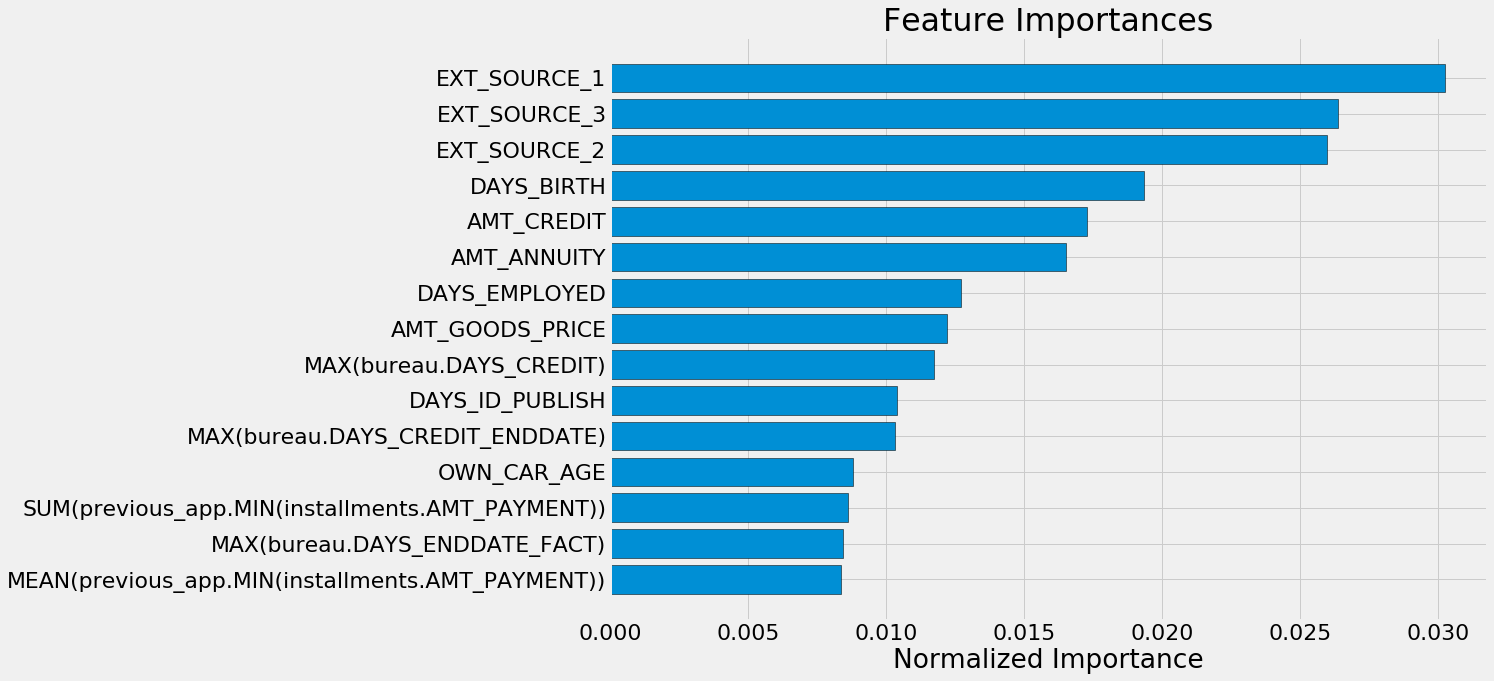

In [32]:
fi = plot_feature_importances(fi)

In [34]:
print('There are %d features with 0 importance' % sum(fi['importance'] == 0.0))

There are 237 features with 0 importance


In [35]:
from featuretools import selection

# Remove features with only one unique value
feature_matrix2 = selection.remove_low_information_features(feature_matrix)

print('Removed %d features' % (feature_matrix.shape[1]- feature_matrix2.shape[1]))

Removed 241 features


In [42]:
# Separate out the train and test sets
train = feature_matrix2[feature_matrix2['set'] == 'train']
test = feature_matrix2[feature_matrix2['set'] == 'test']

# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Align dataframes on the columns

train, test = train.align(test, join = 'inner', axis = 1)
test = test.drop(columns = ['TARGET'])

print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (1001, 1608)
Final Testing Shape:  (1001, 1607)


In [43]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation. 

    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, boosting_type = 'goss',
                   objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 

    return submission, feature_importances, metrics